In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import datasets 
from tensorflow.keras.models import Model # 함수를 이용해서 신경망 모델을 만든다.
from tensorflow.keras.layers import Input # 함수형 신경망에서 입력 데이터의 형태를 지정하기 위해 import
from tensorflow.keras.layers import Conv2D # 신경망에 추가할 합성곱 레이어를 생성한다.
from tensorflow.keras.layers import MaxPool2D  # 맥스 풀링 레이어를 생성한다.

# 다운 샘플링(Down Sampling)은 이미지의 크기를 줄여가며 특징을 추출하는 과정이고, 
# 업 샘플링(Up Sampling)은 다운 샘플링된 이미지를 원래 이미지로 복원하는 과정이다.
from tensorflow.keras.layers import UpSampling2D # 업샘플링 레이어를 추가한다.

***
오토 인코더(Auto Encoder)
***
오토 인코더는 신경망의 한 종류로 데이터를 코드(Code)라고 부르는 은닉층으로 인코딩하는 인코더(Encoder) 부분과 인코딩된 코드를 다시 디코딩(Decoder)로 구성되어 있다.  
인코딩은 원래 데이터를 차원 축소하는 것을 말하고, 디코딩은 차원 축소된 데이터를 다시 원래 데이터로 복원하는 것을 의미한다.  

<img src="오토인코더1.png">

오토 인코더의 시작은 차원 축소와 관련이 있는데 초기 인코던느 주성분 분석과 같은 차원 축소를 위해 사용했지만, 현재는 데이터 생성 모형으로 쓰인다.  

***
오토 인코더를 이용해 손글씨 이미지 데이터의 노이즈를 제거한다.
***

In [2]:
# 일관된 결과값이 나오도록 numpy와 tensorflow의 seed를 설정한다. 
np.random.seed(0)
tf.random.set_seed(0)

***
오토 인코더에 사용할 데이터 준비
***

In [3]:
# 손글씨 데이터셋을 학습 데이터와 테스트 데이터로 저장한다.
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

#오리지널 데이터 확인
print( x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


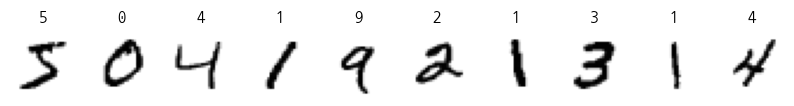

In [4]:
#오리지널 데이터 시각화
plt.figure(figsize=[10, 7])
for i in range(10) :
     plt.subplot(1, 10, (i  + 1))
     plt.imshow(x_train[i], cmap=plt.cm.gray_r)
     plt.axis("off")
     plt.title(y_train[i])
plt.show()



In [5]:
# 클래스(레이블)의 종류 확인; 분류 / 회귀 문제 확인
print(set(y_train))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
# 피쳐 데이터 차원 변경
# 오리지널 데이터의 차원은 (이미지갯수, 행, 열) 형태의 3차원 데이터로 표현이 돼 있지만 합성곱 신경망에 데이터를 넣으려면 4차원 형태로 구성해야한다. 
# 합성곱 신경망은 입력 데이터를 (이미지 갯수, 행, 열, 채널갯수) 형태로 구성해야 한다.
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape, x_test.shape)

#피쳐 데이터 스케일 조정
x_train = x_train / 255
x_test = x_test / 255

(60000, 28, 28, 1) (10000, 28, 28, 1)


***
오리지널 데이터에 노이즈를 추가한 데이터를 만든다.
***

In [7]:
#  MNIST 데이터셋은 노이즈를 따로 제공하지 않으므로, 오리지널 학습 데이터에 랜덤값을 더해서 노이츠가 추가된 데이터를 만들기위해 노이즈 데이터를 생성한다.
# 랜덤값은 -1 에서 1사이의 값을 가지며, 오리지널 학습 데이터와 테스트 데이터의 차원과 일치시켜 만든다.
x_train_noise = x_train + np.random.uniform(-1, 1, size=x_train.shape)
x_test_noise = x_test + np.random.uniform(-1, 1, size=x_test.shape)

#오리지널 데이터에 노이즈를 추가한 데이터 확인
print( x_train_noise.shape, x_test_noise.shape )

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [8]:
# 노이즈 데이터 스케일링
# 노이즈 데이터를 생성하는 과정에서 픽셀값이 0보다 작아지거나 1보다 커질 가능성아 있어 스케일을 조정한다.
# numpy의 clip() 메소드를 사용하면 값의 범위를 a_min, a_max 속성값 사이의 값으로 조정한다.
# a_min=0으로 지정하면 0보다 작은 값은 모두 0이 되고, a_max=1로 지정하면 1보다 큰 값은 모두 1이된다.
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

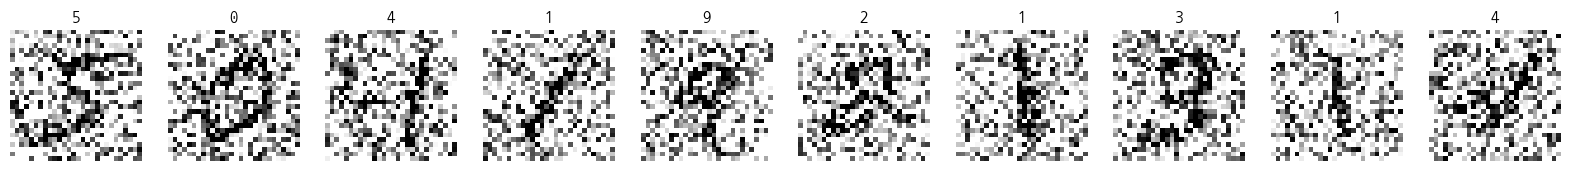

In [9]:
#오리지널 데이터에 노이즈를 추가한 데이터 시각화
plt.figure(figsize=[20, 14])
for i in range(10) :
     plt.subplot(1, 10, (i  + 1))
     plt.imshow(x_train_noise[i], cmap=plt.cm.gray_r)
     plt.axis("off")
     plt.title(y_train[i])
plt.show()



***
오토 인코더의 인코더 부분으로 사용할 신경망 모델을 만든다.
***

In [10]:
# 인코딩 모델에 추가할 Input 레이어를 만든다.
# input_layer의 output shape은 shape 속성값과 동일
# input_layer의 param은 이전 레이어가 없으므로 0
input_layer = Input(shape=(28, 28, 1)) # 입력데이터 1건의 차원을 지정한다.

#--------------------- Conv2D 레이어
# 인코더 모델에 추가할 Conv2D 레이어를 만든다.
# filters 속성 -> 레이어의 출력 차원 지정
# kernel_size 속성 -> 커널;윈도우 크기를 지정
# padding 속성 -> "same" -> 패딩 적용 -> 입력 데이터의 차원이 유지; 차원 축소되지 않음; 출력도 입력과 동일한 차원임
# Conv2D의 Output Shape -> padding 속성값 -> "valid" -> padding 속성값과 filters 의해 결정
# padding 속성값 -> "valid" -> [입력 데이터의 차원(28) + 1 - 커널의 차원(5)] -> 데이터의 차원이 변경 -> (None, 24, 24, 32)
# padding 속성값 -> "same" -> 데이터의 차원이 변경되지 않음 -> (None, 28, 28, 32)
# Conv2D의 Param [커널의 크기 (5 * 5)* 입력 채널 크기(1) * 필터 크기 (32) + 필터마다 1개씩의 바이어스(32)]
conv_layer = Conv2D(filters=32, kernel_size=[5, 5], padding="same", activation="relu")(input_layer)


#--------------------- 출력 레이어
# 인코더 모델에 추가할 출력 레이어를 만든다.
# pool_size -> 맥스 풀링 실행할 픽셀 크기를 지정 -> default (2, 2)
# 맥스 풀링 레이어의 Output shape -> [입력 데이터의 차원 (28)/ pool_size의 차원(2)]
# 맥스 풀링 레이어의 Param -> 없음 -> 0
output_layer = MaxPool2D(pool_size=(2, 2), padding="same")(conv_layer)

#인코더 모델을 만든다.
# Model 객체에 입력 레이어와 출력 레이어를 넘겨 모델 생성
encoder = Model(input_layer, output_layer)


encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


***
오토 인코더의 디코더 부분으로 사용할 신경망 모델을 만든다.
***

In [11]:
# 디코더는 인코딩의 출력을 입력으로 받아야한다. 
print(output_layer.shape)
print(output_layer.shape[1:len(output_layer.shape)])
print(output_layer.shape[1:4])

(None, 14, 14, 32)
(14, 14, 32)
(14, 14, 32)


In [12]:
# 디코더 모델에 추가할 Input 레이어를 만든다.
# 디코더 모델의 Input 레이어에 입력되는 데이터 차원은 인코더 모델의 출력 차원과 동일
# input_layer의 output shape은 shape 속성값과 동일 (None, 14, 14, 32)
# input_layer의 param은 이전 레이어가 없으므로 0
input_layer = Input(shape=output_layer.shape[1:len(output_layer.shape)])

#---------------------- 히든 레이어 Conv2D 레이어
# 디코더 모델에 추가할 히든 레이어를 만든다.
# Conv2D의 Output Shape -> padding 속성값 -> "valid" -> padding 속성값과 filters 의해 결정
# padding 속성값 -> "same" -> 데이터의 차원이 변경되지 않음 -> (None, 14, 14, 10)
# Conv2D의 Param [커널의 크기 (5 * 5)* 입력 채널 크기(32) * 필터 크기 (10) + 필터마다 1개씩의 바이어스(10)] -> 8010
conv_layer = Conv2D(filters=10, kernel_size=[5, 5], padding="same", activation="relu")(input_layer)

#--------------------------- Upsampling2d 레이어
# 디코더 모델에 줄어들었던 차원을 다시 늘려주기 위해 Upsampling2D 레이어를 만든다.
# UpSampling2D 레이어의 output shape은 이미지가 압축되기 전의 차원으로 복원한다. [None, 28, 28, 10]
# UpSampling2D 레이어의 Param은 없으므로 0
conv_layer = UpSampling2D()(conv_layer)

# 디코더 모델에 추가할 output 레이어를 만든다.
# 최종 출력 채널의 갯누는 최초 입력 이미지의 채널 수와 같아야 하므로 filters 속성값 -> 1
# Conv2D의 Output Shape -> padding 속성값 -> "valid" -> padding 속성값과 filters 의해 결정
# padding 속성값 -> "same" -> 데이터의 차원이 변경되지 않음 -> (None, 28, 28, 1)
# Conv2D의 Param [커널의 크기 (5 * 5)* 입력 채널 크기(10) * 필터 크기 (1) + 필터마다 1개씩의 바이어스(1)] -> 251
output_layer = Conv2D(filters=1, kernel_size=[5, 5], padding="same", activation="relu")(conv_layer)


# 디코더 모델을 만든다.
# Model 객체에 입력 레이어와 출력 레이어를 넘겨 모델 생성
decoder = Model(input_layer, output_layer)


decoder.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 32)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        8010      
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
Total params: 8,261
Trainable params: 8,261
Non-trainable params: 0
_________________________________________________________________


***
인코더 모델과 디코더 모델을 합쳐서 오토 인코더 신경망 모델을 만든다.
***

In [13]:
# 오토 인코더는 최초 입력값을 인코더에 먼저 넣고, 그 결과로 나온 출력을 디코더에 넣는다.
# 오토 인코더 모델에 추가할 입력 레이어를 만든다.
input_auto = Input(shape=(28, 28, 1))

# 오토 인코더 모델에 추가할 출력 레이어를 만든다.
# 인코더의 Output shape은 인코더 신경망 최종 출력의 output shape을 따른다. -> (None, 14, 14, 32)
# 인코더의 Param은 인코더 신경망의 모든 Param을 더한 값 -> 832
# 디코더의 Output shape은 인코더 신경망 최종 출력의 output shape을 따른다. -> (None, 28, 28, 1)
# 디코더의 Param은 인코더 신경망의 모든 Param을 더한 값 -> 8261
output_auto = decoder(encoder(input_auto))

# Model 객체에 입력 레이어와 출력 레이어를 넘겨 모델 생성
auto_encoder = Model(input_auto, output_auto)

auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 14, 14, 32)        832       
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         8261      
                                                                 
Total params: 9,093
Trainable params: 9,093
Non-trainable params: 0
_________________________________________________________________


***
오토인코더 신경망 모델 컴파일
***

In [14]:
# compile() 메소드로 생성한 신경망 모델을 컴파일 한다.
# 분류 신경망은 loss라는 속성에 손실함수(비용함수, 오차함수)를 지정할 때 레이블의 분류 결과 범주가 이진 분류일 경우 "binary_crossentropy"를 지정하고,
# 3개 이상의 클래스로 분류할 경우 "categorical_crossentropy"를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 "adam";Adam Optimizer)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
auto_encoder.compile(loss="mean_squared_error", optimizer="adam", metrics="mean_squared_error")

***
오토인코더 신경망 모델 학습
***

In [15]:
# fit() 메소드로 학습 데이터, 원-핫 인코딩된  학습데이터에 따른 레이블, epoch 속성에 학습 횟수, batch-size 속성에 미니 배치 크기를 지정해 컴파일된 신경망 모델을 학습시킨다.
history = auto_encoder.fit( x_train_noise, x_train, epochs=10 , batch_size=100)

Epoch 1/10
600/600 [==============================] - 57s 95ms/step - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 2/10
600/600 [==============================] - 56s 93ms/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 3/10
600/600 [==============================] - 56s 93ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 4/10
600/600 [==============================] - 56s 93ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 5/10
600/600 [==============================] - 56s 94ms/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 6/10
600/600 [==============================] - 57s 94ms/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 7/10
600/600 [==============================] - 56s 94ms/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 8/10
600/600 [==============================] - 58s 97ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 9/10
600/600 [==============================] - 59s 98ms/step - loss: 0.0141 - mean_squared_error:

***
오토인코더 신경망 모델 예측
***

In [16]:
# predict() 메소드의 테스트 피쳐 데이터를 넘겨서 에측값을 계산
predict = auto_encoder.predict(x_test_noise)


313/313 [==============================] - 3s 8ms/step


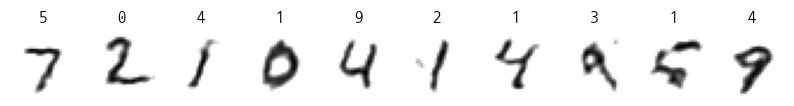

In [17]:
#오리지널 데이터 시각화
plt.figure(figsize=[10, 7])
for i in range(10) :
     plt.subplot(1, 10, (i  + 1))
     plt.imshow(predict[i], cmap=plt.cm.gray_r)
     plt.axis("off")
     plt.title(y_train[i])
plt.show()
